In [1]:
from dataclasses import dataclass
from typing import Callable, List, Tuple


import matplotlib.pyplot as plt
import numpy as np


In [2]:
@dataclass
class QA:
    w: np.array
    feat_funcs: List[Callable[[float, float], float]]
    reg_coef: float = 0.001

    def phi(self, state) -> np.array:
        return np.array([func(state[1], state[0]) for func in self.feat_funcs])

    def evaluate(self, state):
        return self.phi(state).T @ self.w


@dataclass
class AmericanOptionLSPI:
    init_price: float
    r: float
    sigma: float
    K: float
    maturity_time: float
    num_steps: int

    def payoff(self, price) -> float:
        return np.max(self.K - price, 0)

    def generate_price_paths(self, num_paths: int):
        state_transitions: List[Tuple[float, float, float]] = []
        dt = self.maturity_time / self.num_steps
        for _ in range(num_paths):
            curr_price: float = self.init_price
            for step in range(self.num_steps):
                next_price = curr_price * np.exp(
                    (self.r - self.sigma ** 2 / 2) * dt
                    + (self.sigma * np.sqrt(dt)) * np.random.randn()
                )
                time_index: float = step * dt
                state_transitions.append((time_index, curr_price, next_price))
                curr_price = next_price
        return state_transitions

    def lspi(
        self, state_transitions: List[Tuple[float, float, float]], training_iters: int
    ) -> QA:

        feat_funcs: List[Callable[[float, float], float]] = [
            lambda s, t: 1.0,
            lambda s, t: np.exp(-s / (self.K * 2)),
            lambda s, t: np.exp(-s / (self.K * 2)) * (1 - (s / self.K)),
            lambda s, t: np.exp(-s / (self.K * 2))
            * (1 - 2 * (s / self.K) + (s / self.K) ** 2 / 2),
            lambda s, t: np.sin(
                np.pi * (self.maturity_time - t) / (2 * self.maturity_time)
            ),
            lambda s, t: np.log(self.maturity_time - t),
            lambda s, t: np.square(t / self.maturity_time),
        ]
        n_ffs = len(feat_funcs)

        qa = QA(w=np.ones(n_ffs), feat_funcs=feat_funcs)

        dt = self.maturity_time / self.num_steps
        discount_factor = np.exp(-self.r * dt)

        reg_mat = np.eye(n_ffs) * qa.reg_coef
        for _ in range(training_iters):

            A = np.zeros((n_ffs, n_ffs))
            b = np.zeros(n_ffs)

            for state in state_transitions:
                time_idx = state[0]
                curr_price = state[1]
                next_price = state[2]

                curr_state = (time_idx, curr_price)
                next_state = (time_idx, next_price)
                continuation: bool = qa.evaluate(next_state) >= self.payoff(next_price)
                A += np.outer(
                    qa.phi(curr_state),
                    qa.phi(curr_state)
                    - continuation * discount_factor * qa.phi(next_state),
                )
                b += (
                    discount_factor
                    * (
                        not continuation
                        or np.abs(dt + time_idx - self.maturity_time) < 1.0e-8
                    )
                    * qa.phi(next_state)
                    * self.payoff(next_price)
                )
            A /= len(state_transitions)
            A += reg_mat

            b /= len(state_transitions)

            w_star = np.linalg.solve(A, b)
            qa.w = w_star
        return qa


In [3]:
ao = AmericanOptionLSPI(
    init_price=100.0, r=0.05, sigma=0.25, K=100.0, maturity_time=1.0, num_steps=200
)

D = ao.generate_price_paths(num_paths=100)
qa = ao.lspi(state_transitions=D, training_iters=8)


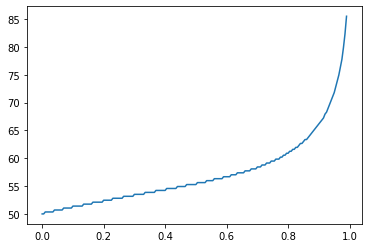

In [4]:
# plot optimal exercise boundary

ts = []
ps = []
for t in np.linspace(0, 0.99, num=199):
    for p in np.linspace(50, 120, 200):
        if qa.evaluate((t, p)) > ao.payoff(p):
            ts.append(t)
            ps.append(p)
            break
plt.plot(ts, ps)